# Import all the packages used

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import vampnet
from vampnet import data_generator as vamp_data_loader
from keras.models import Model
from keras.layers import Dense, Activation, Flatten, Input, BatchNormalization, concatenate
from keras import optimizers
import tensorflow as tf
import matplotlib.gridspec as gridspec
from keras.backend import clear_session

/storage/mi/pasquali/miniconda3/envs/deeptime/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Necessary for downloading the trajectory data
import mdshare
import pyemma.coordinates as pycoor

# Define Hyperparameters

In [3]:
# Tau, how much is the timeshift of the two datasets
tau = 8

# Batch size for Stochastic Gradient descent
batch_size = 10000

# Which trajectory points percentage is used as training
train_ratio = 0.9

# How many hidden layers the network has
network_depth = 6

# Width of every layer
layer_width = 100

# Learning rate used for the ADAM optimizer
learning_rate = 5e-4

# How many output states the network has
output_size = 4

# Iteration over the training set in the fitting process
nb_epoch = 60

epsilon = 1e-5

# Initialized the VAMPnets wrapper class

In [4]:
vamp = vampnet.VampnetTools(epsilon = epsilon)

# Load Data

In [5]:
#Download alanine coordinates and dihedral angles data
mdshare.load('alanine-dipeptide-3x250ns-heavy-atom-positions.npz')
mdshare.load('alanine-dipeptide-3x250ns-backbone-dihedrals.npz')

alanine_files = np.load('alanine-dipeptide-3x250ns-heavy-atom-positions.npz')

# Save the files separately
np.save('traj0.npy', alanine_files['arr_0'])
np.save('traj1.npy', alanine_files['arr_1'])
np.save('traj2.npy', alanine_files['arr_2'])

# Separate data files between training data and validation data

train_data_files_list = [
    'traj0.npy',
    'traj1.npy',
]

valid_data_files_list = [
    'traj2.npy',
]

total_data_files_list = train_data_files_list + valid_data_files_list

/storage/mi/pasquali/miniconda3/envs/deeptime/lib/python3.6/site-packages/pyemma/__init__.py:91: UserWarning: You are not using the latest release of PyEMMA. Latest is 2.5.1, you have 2.4.
  .format(latest=latest, current=current), category=UserWarning)


In [6]:
# Define the pyemma data sources and get basic info from the files, number of datapoints and system size

train_data_source = pycoor.source(train_data_files_list,chunksize = batch_size)
valid_data_source = pycoor.source(valid_data_files_list,chunksize = batch_size)
total_data_source = pycoor.source(total_data_files_list,chunksize = batch_size)

train_datapoints = train_data_source.n_frames_total()
valid_datapoints = valid_data_source.n_frames_total()
total_datapoints = total_data_source.n_frames_total()
                           
traj_lengths = total_data_source.trajectory_lengths()

input_size = total_data_source.dimension()

# Run several model iterations saving the best one, to help finding sparcely populated states

In [ ]:
max_vm = 0
attempts_number = 10


# Pretraining with VAMP with 'symmetrized' matrices yields a bad approximation of the 
# eigenvectors per se, but improves the 'readability' of the states identified by VAMP-2
# which would otherwise be difficult to interprete.
losses = [
          vamp.loss_VAMP2_autograd, 
          vamp._loss_VAMP_sym, 
          vamp.loss_VAMP2_autograd,
]


for attempt in range(attempts_number):
    

    # Clear the previous tensorflow session to prevent memory leaks
    clear_session()

    # Build the model


    nodes = [layer_width]*network_depth

    Data_X = Input(shape = (input_size,))
    Data_Y = Input(shape = (input_size,))

    # A batch normalization layer improves convergence speed
    bn_layer = BatchNormalization()

    # Instance layers and assign them to the two lobes of the network
    dense_layers = [Dense(node, activation = 'relu',)
                    for node in nodes]

    lx_branch = bn_layer(Data_X)
    rx_branch = bn_layer(Data_Y)

    for i, layer in enumerate(dense_layers):

        lx_branch = dense_layers[i](lx_branch)
        rx_branch = dense_layers[i](rx_branch)


    # Add a softmax output layer.
    # Should be replaced with a linear activation layer if
    # the outputs of the network cannot be interpreted as states
    softmax = Dense(output_size, activation='softmax')

    lx_branch = softmax(lx_branch)
    rx_branch = softmax(rx_branch)

    # Merge both networks to train both at the same time
    merged = concatenate([lx_branch, rx_branch])

    # Initialize the model and the optimizer, and compile it with
    # the loss and metric functions from the VAMPnets package
    model = Model(inputs = [Data_X, Data_Y], outputs = merged)
    adam = optimizers.adam(lr = learning_rate)

    vm1 = np.zeros((len(losses), nb_epoch))
    tm1 = np.zeros_like(vm1)
    vm2 = np.zeros_like(vm1)
    tm2 = np.zeros_like(vm1)
    
    for l_index, loss_function in enumerate(losses):

        
        model.compile(optimizer = adam,
                      loss = loss_function,
                      metrics = [
                          vamp.metric_VAMP,
                          vamp.metric_VAMP2,
                                 ])


        # Train the model
        
        steps_per_train_epoch = np.sum(np.ceil((train_data_source.trajectory_lengths()-tau)/batch_size))
        steps_per_valid_epoch = np.sum(np.ceil((valid_data_source.trajectory_lengths()-tau)/batch_size))
        
        hist = model.fit_generator(generator = vamp_data_loader.build_generator_on_source(train_data_source,
                                                              batch_size,
                                                              tau,
                                                              output_size),
                                   steps_per_epoch = steps_per_train_epoch,
                                   epochs = nb_epoch,
                                   verbose = 0,
                                   validation_data = vamp_data_loader.build_generator_on_source(valid_data_source,
                                                                    batch_size,
                                                                    tau,
                                                                    output_size),
                                   validation_steps = steps_per_valid_epoch,
                                   shuffle = True
                                  )


        vm1[l_index] = np.array(hist.history['val_metric_VAMP'])
        tm1[l_index] = np.array(hist.history['metric_VAMP'])
        
        vm2[l_index] = np.array(hist.history['val_metric_VAMP2'])
        tm2[l_index] = np.array(hist.history['metric_VAMP2'])
        
    
    vm1 = np.reshape(vm1, (-1))
    tm1 = np.reshape(tm1, (-1))
    vm2 = np.reshape(vm2, (-1))
    tm2 = np.reshape(tm2, (-1))

    # Average the score obtained in the last part of the training process
    # in order to estabilish which model is better and thus worth saving


    score = vm1[-5:].mean()
    t_score = tm1[-5:].mean()
    extra_msg = ''
    if score > max_vm:
        extra_msg = ' - Highest'
        best_weights = model.get_weights()
        max_vm = score
        vm1_max = vm1
        tm1_max = tm1
        vm2_max = vm2
        tm2_max = tm2
        
    print('Attempt {0}, training score: {1:.2f}, validation score: {2:.2f}'.format(attempt+1, t_score, score) + extra_msg)

/storage/mi/pasquali/miniconda3/envs/deeptime/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:98: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Attempt 1, training score: 1.10, validation score: 1.32 - Highest


# Recover the saved model and its training history

In [17]:
model.set_weights(best_weights)

tm1 = np.array(vm1_max)
tm2 = np.array(tm1_max)
vm1 = np.array(vm2_max)
vm2 = np.array(tm2_max)

# Training result visualization

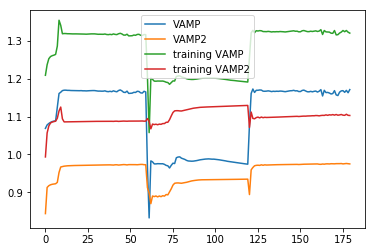

In [18]:
plt.plot(vm1, label = 'VAMP')
plt.plot(vm2, label = 'VAMP2')
plt.plot(tm1, label = 'training VAMP')
plt.plot(tm2, label = 'training VAMP2')
plt.legend()
plt.show()

In [19]:
# Transform the input trajectory using the network
states_prob = model.predict_generator(generator = vamp_data_loader.build_generator_on_source(total_data_source,
                                                              batch_size,
                                                              tau,
                                                              output_size),
                                     steps = np.sum(np.ceil((total_data_source.trajectory_lengths()-tau)/batch_size)),
                                     verbose = 0)[:, :output_size]


# Order the output states based on their population
coor_pred = np.argmax(states_prob, axis = 1)
indexes = [np.where(coor_pred == np.multiply(np.ones_like(coor_pred), n)) for n in range(output_size)]
states_num = [len(i[0]) for i in indexes]
states_order = np.argsort(states_num).astype('int')[::-1]

pred_ord = states_prob[:,states_order]

# Visualize the population of the states

States population: [64.60393399 32.41130383  2.84315765  0.14160453]%


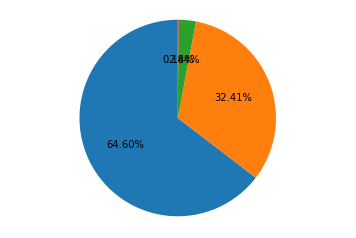

In [20]:
def print_states_pie_chart():
    coors = []
    maxi = np.max(pred_ord, axis= 1)

    for i in range(output_size):
        coors.append(len(np.where(pred_ord[:,i] == maxi)[0]))
        
    fig1, ax1 = plt.subplots()
    ax1.pie(np.array(coors), autopct='%1.2f%%', startangle=90)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    print('States population: '+str(np.array(coors)/len(maxi)*100)+'%')
    plt.show()

print_states_pie_chart()

# Visualize how the 4 states are placed on the Ramachandran plot

In [21]:
dihedral_file = np.load('alanine-dipeptide-3x250ns-backbone-dihedrals.npz')
dihedral_init = np.concatenate([dihedral_file['arr_0'][:-tau],
                                dihedral_file['arr_1'][:-tau],
                                dihedral_file['arr_2'][:-tau],
                               ], axis = 0)


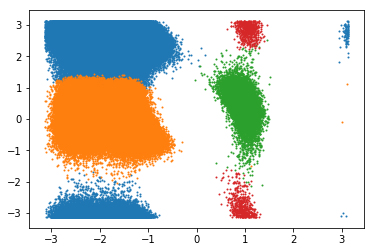

In [22]:
maxi_train = np.max(pred_ord, axis= 1)
coor_train = np.zeros_like(pred_ord)
for i in range(output_size):
    coor_train = np.where(pred_ord[:,i]== maxi_train)[0]
    plt.scatter(dihedral_init[coor_train,0], dihedral_init[coor_train,1], s=1)
plt.axes = [[-np.pi, np.pi],[-np.pi, np.pi]]

# For each state, visualize the probabilities the different trajectory points have to belong to it

/storage/mi/pasquali/miniconda3/envs/deeptime/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/storage/mi/pasquali/miniconda3/envs/deeptime/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


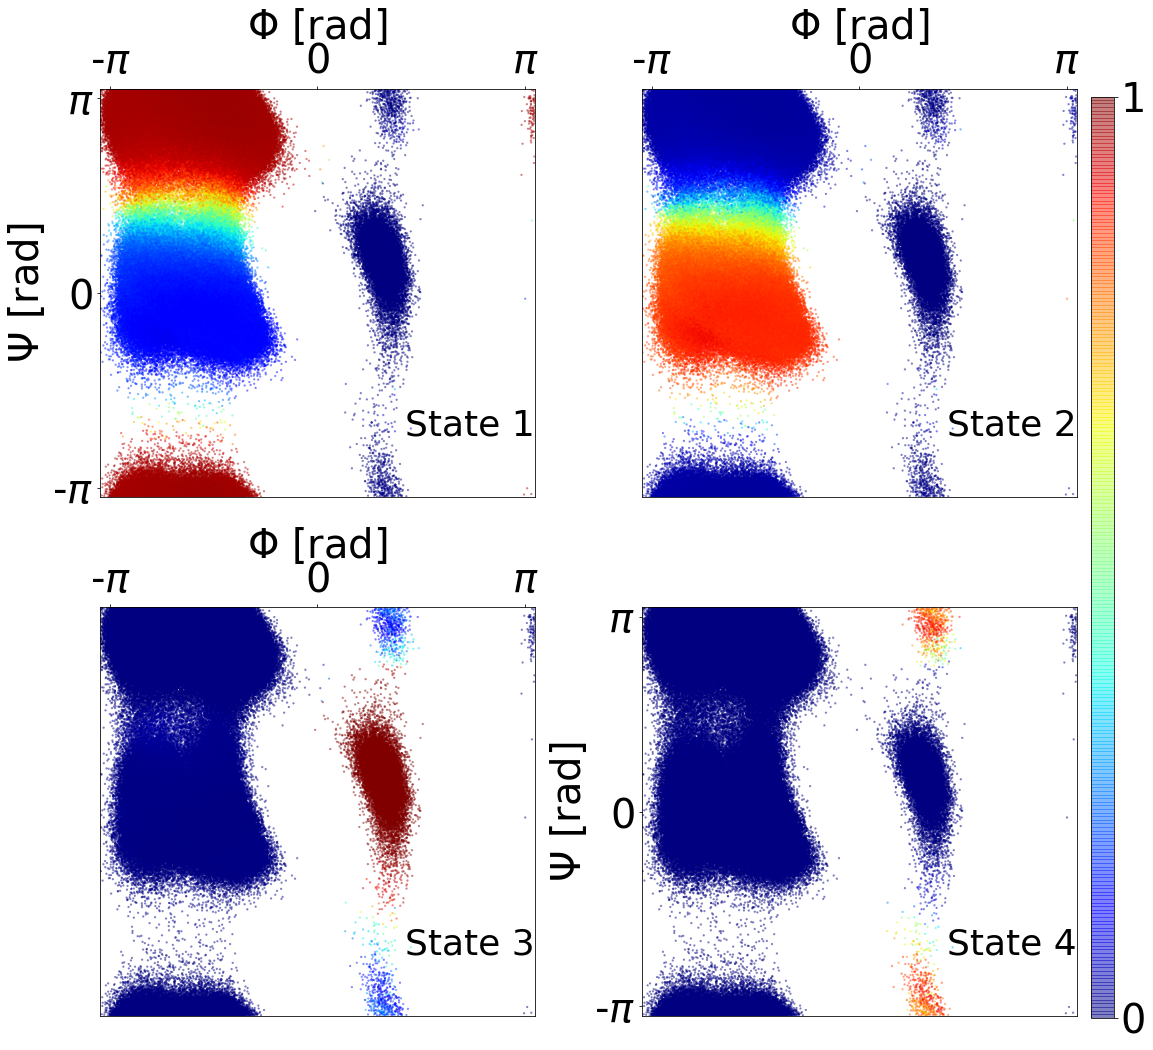

In [23]:
fig = plt.figure(figsize=(16, 16))

gs1 = gridspec.GridSpec(int(np.ceil(output_size/2)), 2)
gs1.update(wspace=0.05, hspace = 0.05)

for n in range(output_size):
    ax = plt.subplot(gs1[n])
    im = ax.scatter(dihedral_init[:,0], dihedral_init[:,1], s=5,
                    c = pred_ord[:,n],
                    alpha=0.5, edgecolor='', vmin = 0, vmax = 1)
    plt.axis('on')
    title = 'State '+str(n + 1)

    ax.text(.85, .15, title,
        horizontalalignment='center',
        transform=ax.transAxes,  fontdict = {'size':36})


    if (n < 3):
        ax.set_xticks([-3, 0, 3])
        ax.set_xticklabels([r'-$\pi$', r'$0$', r'$\pi$'])
        ax.xaxis.set_tick_params(top='on', bottom='off', labeltop='on', labelbottom='off')
        ax.xaxis.set_tick_params(labelsize=40)
    else:
        ax.set_xticks([])
    if (n%3==0):
        ax.set_yticks([-3, 0, 3])
        ax.set_yticklabels([r'-$\pi$', r'$0$', r'$\pi$'])
        ax.yaxis.set_tick_params(labelsize=40)
    else:
        ax.set_yticks([])
#    ax.set_aspect('equal')
    ax.set_xlim([-np.pi, np.pi]);
    ax.set_ylim([-np.pi, np.pi]);
    
    if (n%3 == 0):
        ax.set_ylabel(r'$\Psi$ [rad]', fontdict = {'size':40})
    if (n < 3):
        ax.set_xlabel(r'$\Phi$ [rad]', fontdict = {'size':40}, position = 'top')
        ax.xaxis.set_label_coords(0.5,1.2)

gs1.tight_layout(fig, rect=[0, 0.03, 0.95, 0.94])
fig.show()

cax = fig.add_axes([0.95, 0.05, 0.02, 0.8])
cbar = fig.colorbar(im, cax=cax, ticks=[0, 1])
cbar.ax.yaxis.set_tick_params(labelsize=40)

# Markov Model Estimation

# Estimate the implied timescales

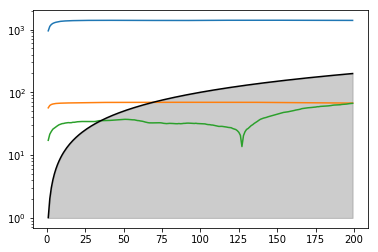

In [24]:
max_tau = 200
lag = np.arange(1, max_tau, 1)
its = vamp.get_its(pred_ord, lag)
vamp.plot_its(its, lag)

# Chapman-Kolmogorov test for the estimated koopman operator

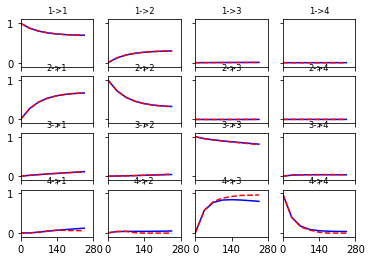

In [25]:
steps = 8
tau_msm = 35
predicted, estimated = vamp.get_ck_test(pred_ord, steps, tau_msm)
vamp.plot_ck_test(predicted, estimated, output_size, steps, tau_msm)